In [1]:
import os
import requests
import pandas as pd
from datetime import datetime

BASE_URL = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/all"
LOCAL_TMP = "./tmp"
os.makedirs(LOCAL_TMP, exist_ok=True)

STATIONS = [
    "USW00023174",  # LAX
    "USW00012921",  # San Antonio
    "USW00094728",  # NYC Central Park
    "USW00023293",  # San Diego Miramar
    "USW00013904",  # Houston Hobby
]

def parse_dly(filepath):
    rows = []
    with open(filepath, "r") as f:
        for line in f:
            station = line[0:11]
            year = int(line[11:15])
            month = int(line[15:17])
            element = line[17:21]
            for day in range(1, 32):
                value = int(line[21 + (day - 1) * 8 : 26 + (day - 1) * 8])
                if value == -9999:
                    continue
                rows.append({
                    "station_id": station,
                    "date": datetime(year, month, day),
                    "element": element,
                    "value": value / 10.0
                })
    return pd.DataFrame(rows)

dfs = []

for station_id in STATIONS:
    url = f"{BASE_URL}/{station_id}.dly"
    local_path = f"{LOCAL_TMP}/{station_id}.dly"

    r = requests.get(url, timeout=60)
    r.raise_for_status()

    with open(local_path, "wb") as f:
        f.write(r.content)

    df = parse_dly(local_path)
    dfs.append(df)

weather_long = pd.concat(dfs, ignore_index=True)
weather_long.head()


,station_id,date,element,value
0,USW00023174,1944-01-01,TAVG,15.0
1,USW00023174,1944-01-02,TAVG,10.9
2,USW00023174,1944-01-03,TAVG,10.5
3,USW00023174,1944-01-04,TAVG,10.8
4,USW00023174,1944-01-05,TAVG,11.6


In [2]:
weather_long["element"].value_counts()


element
TMAX    145778
TMIN    145740
PRCP    145664
SNOW    123165
SNWD    107493
         ...  
WT10         7
WV20         7
TOBS         2
WT12         1
FRGT         1
Name: count, Length: 68, dtype: int64

In [3]:
weather_long["station_id"].nunique()


5

In [4]:
# FILTER TO RELEVANT ELEMENTS FIRST
weather_long_filt = weather_long[
    weather_long["element"].isin(["PRCP", "TMAX", "TMIN"])
]

# PIVOT TO WIDE FORMAT
weather_wide = (
    weather_long_filt
    .pivot_table(
        index=["station_id", "date"],
        columns="element",
        values="value"
    )
    .reset_index()
)

# DROP ROWS WITHOUT PRECIPITATION
weather_wide = weather_wide.dropna(subset=["PRCP"])

# LIMIT TO LAST 20 YEARS
max_date = weather_wide["date"].max()
cutoff_date = max_date - pd.DateOffset(years=20)

weather_wide = weather_wide[
    weather_wide["date"] >= cutoff_date
].copy()


In [5]:
weather_wide["date"].min(), weather_wide["date"].max()


(Timestamp('2006-02-02 00:00:00'), Timestamp('2026-02-02 00:00:00'))

In [6]:
(weather_wide["date"].max() - weather_wide["date"].min()).days / 365


20.013698630136986

In [7]:
weather_wide.groupby("station_id")["date"].agg(["min", "max"])


,min,max
station_id,,
USW00012921,2006-02-02,2026-02-02
USW00013904,2006-02-02,2026-02-02
USW00023174,2006-02-02,2026-02-02
USW00023293,2006-02-02,2026-02-02
USW00094728,2006-02-02,2026-01-31


In [8]:
weather_wide["date"].dt.year.value_counts().sort_index().head(10)



date
2006    1665
2007    1825
2008    1830
2009    1825
2010    1825
2011    1825
2012    1830
2013    1825
2014    1825
2015    1825
Name: count, dtype: int64

In [9]:
weather_wide["date"].dt.year.value_counts().sort_index().tail(10)

date
2017    1825
2018    1825
2019    1825
2020    1830
2021    1825
2022    1824
2023    1824
2024    1830
2025    1820
2026     163
Name: count, dtype: int64

In [10]:
#DEFINE EXTREME PRECIPITATION EVENTS (NEXT-DAY LABEL)

prcp_threshold = weather_wide["PRCP"].quantile(0.95)

weather_wide = weather_wide.sort_values(["station_id", "date"])

weather_wide["extreme_precip"] = (
    weather_wide["PRCP"] >= prcp_threshold
)

# shift label forward (predict tomorrow)
weather_wide["extreme_precip_tomorrow"] = (
    weather_wide
    .groupby("station_id")["extreme_precip"]
    .shift(-1)
)

weather_wide = weather_wide.dropna(subset=["extreme_precip_tomorrow"])


In [11]:
# This cell persists the final modeling dataset to S3

import boto3

AWS_REGION = "us-east-1"
S3_BUCKET = "sagemaker-us-east-1-083422367993"
S3_PREFIX = "ghcn/extreme_precip"

# create s3 client
s3 = boto3.client("s3", region_name=AWS_REGION)

# write final dataset locally
local_path = "extreme_precip_model_data.parquet"
weather_wide.to_parquet(local_path, index=False)

# upload to s3
s3_key = f"{S3_PREFIX}/extreme_precip_model_data.parquet"
s3.upload_file(local_path, S3_BUCKET, s3_key)

print(f"Uploaded to s3://{S3_BUCKET}/{s3_key}")


Uploaded to s3://sagemaker-us-east-1-083422367993/ghcn/extreme_precip/extreme_precip_model_data.parquet


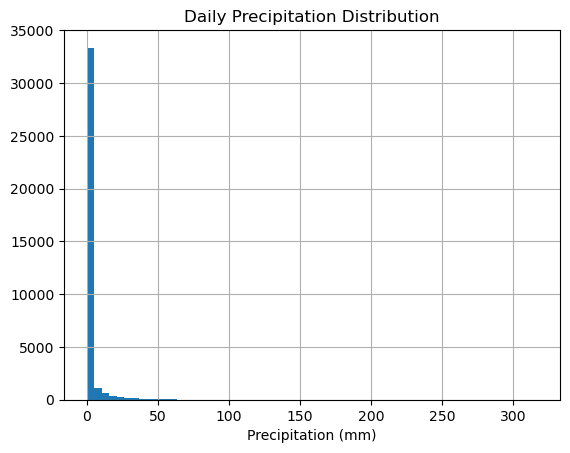

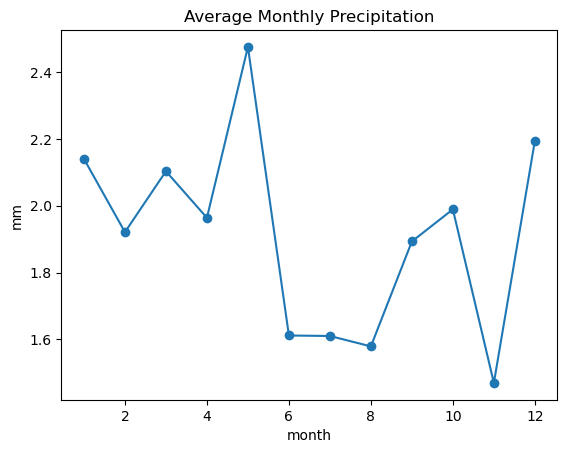

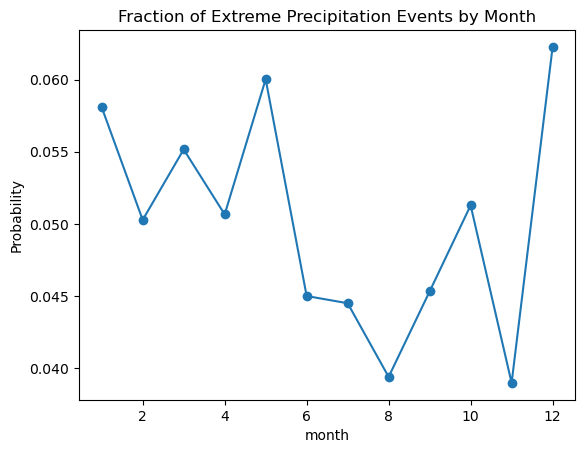

In [12]:
# BASIC EDA (DISTRIBUTION + SEASONALITY)

import matplotlib.pyplot as plt

# precipitation distribution
weather_wide["PRCP"].dropna().hist(bins=60)
plt.title("Daily Precipitation Distribution")
plt.xlabel("Precipitation (mm)")
plt.show()

# seasonal pattern
weather_wide["month"] = weather_wide["date"].dt.month

weather_wide.groupby("month")["PRCP"].mean().plot(marker="o")
plt.title("Average Monthly Precipitation")
plt.ylabel("mm")
plt.show()

# extreme events by month
weather_wide.groupby("month")["extreme_precip"].mean().plot(marker="o")
plt.title("Fraction of Extreme Precipitation Events by Month")
plt.ylabel("Probability")
plt.show()


In [13]:
# MODELING TABLE (NEXT-DAY TARGET)

weather_wide = weather_wide.sort_values(["station_id", "date"])

weather_wide["prcp_lag_1"] = (
    weather_wide.groupby("station_id")["PRCP"].shift(1)
)

weather_wide["prcp_roll_7"] = (
    weather_wide.groupby("station_id")["PRCP"]
    .rolling(7)
    .mean()
    .reset_index(0, drop=True)
)

model_df = weather_wide[
    [
        "station_id",
        "date",
        "prcp_lag_1",
        "prcp_roll_7",
        "TMAX",
        "TMIN",
        "extreme_precip_tomorrow",
    ]
].dropna().copy()


In [14]:
model_df.head()
model_df.columns


Index(['station_id', 'date', 'prcp_lag_1', 'prcp_roll_7', 'TMAX', 'TMIN',
       'extreme_precip_tomorrow'],
      dtype='object', name='element')

In [15]:
output_path = "extreme_precip_model_data.parquet"
model_df.to_parquet(output_path, index=False)


In [16]:
output_path = "extreme_precip_model_data.csv"
model_df.to_csv(output_path, index=False)


In [17]:
# time-based train / test split (80 / 20)
split_date = model_df["date"].quantile(0.8)

train_df = model_df[model_df["date"] <= split_date]
test_df  = model_df[model_df["date"] > split_date]

train_df.shape, test_df.shape


((29165, 7), (7286, 7))

*****************************************************